# 0. Imports and Seeds

In [1]:
# import relevant packages
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import itertools
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.datasets import MNIST
from sklearn.manifold import TSNE

In [2]:
# set seeds for reproducibility
seed = 310
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # for multi-GPU setups, if applicable

# 1. Autoencoders

In [3]:
class EncoderCNN(nn.Module):
    """
    EncoderCNN is a convolutional neural network that encodes input images into a latent representation.

    Args:
        latent_dim (int): The dimensionality of the latent representation.
        input_channels (int, optional): Number of channels in the input image. Defaults to 3.
        covariate_dim (int, optional): Dimensionality of additional covariate inputs. Defaults to None.

    Methods:
        forward(x, covariates=None):
            Computes the latent representation of the input image, optionally conditioned on covariates.

            Args:
                x (Tensor): Input image tensor of shape (batch_size, input_channels, height, width).
                covariates (Tensor, optional): Additional covariates tensor of shape (batch_size, covariate_dim).

            Returns:
                Tensor: Latent representation of the input.
    """
    def __init__(self, latent_dim, input_channels=3, covariate_dim=None):
        super(EncoderCNN, self).__init__()

        covariate_dim = covariate_dim if covariate_dim is not None else 0

        # initialize convolutional layers
        self.conv1 = nn.Conv2d(in_channels=input_channels, out_channels=32, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1)

        # dropout layer for regularization
        self.dropout = nn.Dropout(0.3)  # dropout probability of 30%

        # determine the flattened size after convolutions
        self.flattened_size = 128 * 3 * 3

        # fully connected layers
        self.fc1 = nn.Linear(self.flattened_size + covariate_dim, 512)
        self.fc2 = nn.Linear(512, latent_dim)

    def forward(self, x, covariates=None):
        # pass through convolutional layers
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        # flatten the output
        x = x.view(x.size(0), -1)

        if covariates is not None:
            x = torch.cat((x, covariates), dim=1)

        # apply dropout for regularization before the fully connected layers
        x = self.dropout(x)

        # fully connected layers
        x = F.relu(self.fc1(x)) # this introduces non-linearity after the first fully connected layer
        z = self.fc2(x)

        # return latent representation and covariate prediction
        return z

In [4]:
class FiLM(nn.Module):
    """
    FiLM (Feature-wise Linear Modulation) layer for conditioning convolutional layers on covariates.

    Args:
        input_dim (int): Dimensionality of the covariate input.
        output_dim (int): Dimensionality of the modulation parameters to be applied to feature maps.

    Methods:
        forward(x, covariate):
            Modulates feature maps based on covariate values.

            Args:
                x (Tensor): Input feature maps of shape (batch_size, num_features, height, width).
                covariate (Tensor): Covariate tensor of shape (batch_size, input_dim).

            Returns:
                Tensor: Modulated feature maps.
    """
    def __init__(self, input_dim, output_dim):
        super(FiLM, self).__init__()
        self.gamma = nn.Linear(input_dim, output_dim)
        self.beta = nn.Linear(input_dim, output_dim)

    def forward(self, x, covariate):
        gamma = self.gamma(covariate).view(-1, x.size(1), 1, 1)
        beta = self.beta(covariate).view(-1, x.size(1), 1, 1)
        return gamma * x + beta

In [5]:
class DecoderCNN(nn.Module):
    """
    DecoderCNN is a convolutional neural network that decodes latent representations back into images,
    with conditioning on covariates via FiLM layers.

    Args:
        latent_dim (int): Dimensionality of the latent representation.
        output_channels (int, optional): Number of channels in the output image. Defaults to 3.
        covariate_dim (int, optional): Dimensionality of covariate inputs. Defaults to None.

    Methods:
        forward(z, covariates):
            Decodes the latent representation into an output image, conditioned on covariates.

            Args:
                z (Tensor): Latent representation tensor of shape (batch_size, latent_dim).
                covariates (Tensor): Covariate tensor of shape (batch_size, covariate_dim).

            Returns:
                Tensor: Reconstructed image tensor of shape (batch_size, output_channels, height, width).
    """
    def __init__(self, latent_dim, output_channels=3, covariate_dim=None):
        super(DecoderCNN, self).__init__()

        covariate_dim = covariate_dim if covariate_dim is not None else 0

        self.fc1 = nn.Linear(latent_dim + covariate_dim, 512)  # increase the first layer size
        self.fc2 = nn.Linear(512, 256)  # add another fully connected layer for better feature extraction
        self.fc3 = nn.Linear(256, 128 * 7 * 7)  # expand to match the expected input for the deconvolution layers

        # define FiLM layers for covariate-based modulation
        if covariate_dim > 0:
            self.film1 = FiLM(covariate_dim, 64)
            self.film2 = FiLM(covariate_dim, 32)

        # deconvolution layers to reconstruct the image
        self.deconv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(32, output_channels, kernel_size=3, stride=1, padding=1)

        # dropout layer for regularization
        self.dropout = nn.Dropout(0.3)

    def forward(self, z, covariates):
        if covariates is not None:
            z = torch.cat((z, covariates), dim=1)

        x = F.relu(self.fc1(z))
        x = self.dropout(x)  # apply dropout for regularization
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = x.view(x.size(0), 128, 7, 7)

        # deconvolution path with FiLM modulation
        # FiLM enables the decoder to adjust the feature maps at each step based on covariate values
        # allowing the reconstruction process to be explicitly conditioned on the covariates
        if covariates is not None:
            x = F.relu(self.deconv1(x))
            x = self.film1(x, covariates)

            x = F.relu(self.deconv2(x))
            x = self.film2(x, covariates)

            x = torch.tanh(self.deconv3(x))  # final layer to produce the output

        else:
            x = F.relu(self.deconv1(x))
            x = F.relu(self.deconv2(x))
            x = torch.tanh(self.deconv3(x))  # final layer to produce the output

        return x

# 2. Prior

In [6]:
# defining the Prior Class
class Prior:
    """
    Base template class for doc-topic priors.
    """

    def __init__(self):
        pass

    def update_parameters(self):
        """
        M-step after each epoch.
        """
        pass

    def sample(self):
        """
        Sample from the prior.
        """
        pass

    def simulate(self):
        """
        Simulate data to test the prior's updating rule.
        """
        pass

class IsotropicGaussianPrior(Prior):
    """
    Isotropic Gaussian prior: P_Z(Z) = N(Z; 0, σ^2_z * I_d)

    This class defines an isotropic Gaussian prior in the latent space.
    """

    def __init__(self, latent_dim, sigma_z, device):
        """
        Initialize the prior with the latent dimension and variance.

        Args:
            latent_dim (int): Dimensionality of the latent space.
            sigma_z (float): Variance for the Gaussian prior.
            device (torch.device): Device for tensor operations.
        """
        self.latent_dim = latent_dim
        self.sigma_z = sigma_z
        self.device = device
        np.random.seed(seed)  # Ensures deterministic behavior for numpy operations

    def sample(self, N):
        """
        Sample from the isotropic Gaussian prior.

        Args:
            N (int): Number of samples to generate.

        Returns:
            torch.Tensor: Samples from the prior (N, latent_dim).
        """
        z = torch.randn(N, self.latent_dim).to(self.device) * self.sigma_z
        return z

    def to(self, device):
        """
        Move the model to a different device.
        """
        self.device = device

# 3. Training and Evaluation Functions

In [7]:
def compute_mmd(x, y, kernel='rbf'):
    """Empirical maximum mean discrepancy. A lower result indicates more similar distributions.

    Args:
        x (torch.Tensor): First sample, distribution P.
        y (torch.Tensor): Second sample, distribution Q.
        kernel (str): Kernel type ('multiscale' or 'rbf').
    """
    # compute pairwise squared distances
    xx = torch.mm(x, x.t())
    yy = torch.mm(y, y.t())
    zz = torch.mm(x, y.t())

    rx = xx.diag().view(1, -1).expand_as(xx)
    ry = yy.diag().view(1, -1).expand_as(yy)

    dxx = rx.t() + rx - 2 * xx  # pairwise distance matrix for x
    dyy = ry.t() + ry - 2 * yy  # pairwise distance matrix for y
    dxy = rx.t() + ry - 2 * zz  # pairwise distance matrix between x and y

    # initialize kernel matrices
    XX = torch.zeros_like(xx).to(device)
    YY = torch.zeros_like(yy).to(device)
    XY = torch.zeros_like(zz).to(device)

    # define kernel computation based on the selected kernel type
    def apply_kernel(matrix, bandwidth_range):
        result = torch.zeros_like(matrix).to(device)
        for bandwidth in bandwidth_range:
            if kernel == 'multiscale':
                result += bandwidth**2 * (bandwidth**2 + matrix).pow(-1)
            elif kernel == 'rbf':
                result += torch.exp(-0.5 * matrix / bandwidth)
        return result

    # apply the kernel function to each pairwise distance matrix
    if kernel in ('multiscale', 'rbf'):
        bandwidths = [0.2, 0.5, 0.9, 1.3] if kernel == 'multiscale' else [10, 15, 20, 50]
        XX = apply_kernel(dxx, bandwidths)
        YY = apply_kernel(dyy, bandwidths)
        XY = apply_kernel(dxy, bandwidths)

    # compute the final MMD value
    return torch.mean(XX + YY - 2 * XY)

In [8]:
def apply_color_tint(images, covariates):
    """
    Applies a color tint to grayscale images based on covariate values.

    Args:
        images (Tensor): Batch of grayscale images of shape (batch_size, 1, height, width).
        covariates (Tensor): Covariate tensor of shape (batch_size, 1).

    Returns:
        Tensor: Batch of color-tinted images of shape (batch_size, 3, height, width).
    """
    batch_size = images.size(0)
    covariates = covariates.view(batch_size, 1, 1, 1)

    # repeat grayscale image across RGB channels
    images_colored = images.repeat(1, 3, 1, 1)

    # create the mask for the green and blue channels
    mask = 1 - covariates  # shape: (batch_size, 1, 1, 1)

    # create a mask tensor for all three channels
    mask_rgb = torch.cat([torch.ones_like(mask), mask, mask], dim=1)

    # apply the mask without in-place operations
    images_colored = images_colored * mask_rgb

    return images_colored

In [9]:
def train_and_evaluate(
    latent_dim, covariate_dim, epochs, lambda_mmd=0.1, patience=5, learning_rate=0.001
):
    """
    Trains and evaluates the Wasserstein Encoder-Decoder model with MMD loss and early stopping.

    Args:
        latent_dim (int): Dimensionality of the latent representation.
        covariate_dim (int): Dimensionality of the covariates.
        epochs (int): Number of training epochs.
        lambda_mmd (float, optional): Weight for the MMD loss term. Defaults to 0.1.
        patience (int, optional): Number of epochs to wait for improvement before early stopping. Defaults to 5.
        learning_rate (float, optional): Learning rate for the optimizer. Defaults to 0.001.

    Returns:
        tuple: Best test loss, trained EncoderCNN model, and trained DecoderCNN model.
    """
    encoder = EncoderCNN(covariate_dim=1, latent_dim=latent_dim, input_channels=3).to(device)
    decoder = DecoderCNN(covariate_dim=covariate_dim, latent_dim=latent_dim, output_channels=3).to(device)
    prior = IsotropicGaussianPrior(latent_dim=latent_dim, sigma_z=sigma_z, device=device)
    optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=learning_rate)
    mse_loss = nn.MSELoss()

    best_test_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        encoder.train()
        decoder.train()

        total_loss = 0.0
        total_rec_loss = 0.0
        total_mmd_loss = 0.0
        num_batches = 0

        for batch in train_loader:
            x, _ = batch
            x = x.to(device)

            batch_size = x.size(0)
            # assign covariates randomly but consistently
            covariates = torch.randint(0, 2, (batch_size, covariate_dim)).float().to(device)

            # generate input images based on covariates (for the encoder)
            x_input = apply_color_tint(x, covariates)

            # generate target images based on covariates
            x_target = apply_color_tint(x, covariates)

            # encode with covariates
            z = encoder(x_input, covariates)

            # decode with covariates
            x_hat = decoder(z, covariates)

            # compute losses
            rec_loss = mse_loss(x_hat, x_target)
            z_true = prior.sample(batch_size)
            mmd_loss = compute_mmd(z, z_true)

            # total loss
            total_batch_loss = rec_loss + lambda_mmd * mmd_loss

            # backpropagation
            optimizer.zero_grad()
            total_batch_loss.backward()
            optimizer.step()

            total_loss += total_batch_loss.item()
            total_rec_loss += rec_loss.item()
            total_mmd_loss += mmd_loss.item()

            num_batches += 1

        avg_train_loss = total_loss / num_batches if num_batches > 0 else 0.0
        avg_train_rec_loss = total_rec_loss / num_batches if num_batches > 0 else 0.0
        avg_train_mmd_loss = (total_mmd_loss / num_batches) * lambda_mmd if num_batches > 0 else 0.0

        print(f"Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}, Avg Reconstruction Loss: {avg_train_rec_loss:.4f}, "
          f"Avg MMD Loss: {avg_train_mmd_loss:.4f}")

        # evaluate the model after each epoch
        test_loss = evaluate_model(
            encoder, decoder, test_loader, prior, covariate_dim, lambda_mmd
        )

        # early stopping check
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            patience_counter = 0
            torch.save(encoder.state_dict(), 'best_encoder.pth')
            torch.save(decoder.state_dict(), 'best_decoder.pth')
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

    # load the best model before returning
    encoder.load_state_dict(torch.load('best_encoder.pth'))
    decoder.load_state_dict(torch.load('best_decoder.pth'))

    return best_test_loss, encoder, decoder

In [10]:
def evaluate_model(
    encoder, decoder, test_loader, prior, covariate_dim, lambda_mmd
):
    """
    Evaluates the Wasserstein Encoder-Decoder model on a test dataset.

    Args:
        encoder (EncoderCNN): Trained EncoderCNN model.
        decoder (DecoderCNN): Trained DecoderCNN model.
        test_loader (DataLoader): DataLoader for the test dataset.
        prior (IsotropicGaussianPrior): Prior distribution for latent space sampling.
        covariate_dim (int): Dimensionality of the covariates.
        lambda_mmd (float): Weight for the MMD loss term.

    Returns:
        float: Average test loss across all batches.
    """
    encoder.eval()
    decoder.eval()

    total_loss = 0.0
    total_rec_loss = 0.0
    total_mmd_loss = 0.0
    num_batches = 0

    mse_loss = nn.MSELoss()

    with torch.no_grad():
        for batch in test_loader:
            x, _ = batch  # grayscale images in [-1, 1]
            x = x.to(device)

            batch_size = x.size(0)

            # generate covariates
            covariates = torch.randint(0, 2, (batch_size, covariate_dim)).float().to(device)

            x_input = x.repeat(1, 3, 1, 1) # to handle the input_channels=3 expected from the encoder, while the input image stays BW

            # apply color tint to input images based on covariates (same as target)
            # this ensures consistency between training and evaluation
            x_target = apply_color_tint(x, covariates)

            # encode the input image
            z = encoder(x_input, covariates)

            # decode using covariates
            x_hat = decoder(z, covariates)

            # compute losses
            # reconstruction loss between the target (which has color) and reconstruction
            rec_loss = mse_loss(x_hat, x_target)

            # compute MMD loss with the prior
            z_true = prior.sample(batch_size)
            mmd_loss = compute_mmd(z, z_true)

            # total loss calculation
            batch_loss = rec_loss + lambda_mmd * mmd_loss

            # accumulate losses for average computation
            total_loss += batch_loss.item()
            total_rec_loss += rec_loss.item()
            total_mmd_loss += mmd_loss.item()
            num_batches += 1

    # compute average losses
    avg_loss = total_loss / num_batches if num_batches > 0 else 0.0
    avg_rec_loss = total_rec_loss / num_batches if num_batches > 0 else 0.0
    avg_mmd_loss = (total_mmd_loss / num_batches) * lambda_mmd if num_batches > 0 else 0.0

    print(f"Average Test Loss: {avg_loss:.4f}, Avg Reconstruction Loss: {avg_rec_loss:.4f}, "
          f"Avg MMD Loss: {avg_mmd_loss:.4f}")

    return avg_loss

# 4. Visualization Functions

In [11]:
def denormalize(img):
    """
    Denormalizes an image tensor from the range [-1, 1] to [0, 1].

    Args:
        img (Tensor): Input image tensor.

    Returns:
        Tensor: Denormalized image tensor.
    """
    return (img + 1) / 2

def visualize_color_reconstructions(encoder, decoder, num_images=5):
    """
    Visualizes original and reconstructed images with different covariates.

    Args:
        encoder (EncoderCNN): Trained EncoderCNN model.
        decoder (DecoderCNN): Trained DecoderCNN model.
        num_images (int, optional): Number of images to visualize. Defaults to 5.

    Displays:
        Matplotlib plots of original grayscale images and their reconstructions with red and grayscale covariates.
    """
    encoder.eval()
    decoder.eval()

    with torch.no_grad():
        for batch in test_loader:
            x, _ = batch
            x = x.to(device)
            batch_size = x.size(0)

            # generate covariates for visualization
            covariate_red = torch.ones((batch_size, 1)).to(device)  # covariate value of 1 to indicate red tint
            covariate_bw = torch.zeros((batch_size, 1)).to(device)  # covariate value of 0 to indicate grayscale

            # repeat grayscale images into RGB channels for the encoder
            x_input = x.repeat(1, 3, 1, 1)

            # encode images with covariate = 1 and covariate = 0
            z_red = encoder(x_input, covariate_red)
            z_bw = encoder(x_input, covariate_bw)

            # decode with covariate = 1 (should produce red tint)
            x_hat_red = decoder(z_red, covariate_red)

            # decode with covariate = 0 (should produce grayscale)
            x_hat_bw = decoder(z_bw, covariate_bw)

            # plot original and reconstructed images
            fig, axs = plt.subplots(num_images, 3, figsize=(9, num_images * 3))
            for i in range(num_images):
                # original grayscale image
                axs[i, 0].imshow(denormalize(x[i, 0].cpu()), cmap='gray')
                axs[i, 0].axis('off')
                axs[i, 0].set_title('Original')

                # reconstructed with covariate = 1 (red)
                axs[i, 1].imshow(denormalize(x_hat_red[i].permute(1, 2, 0).cpu()))
                axs[i, 1].axis('off')
                axs[i, 1].set_title('Reconstructed Red')

                # reconstructed with covariate = 0 (grayscale)
                axs[i, 2].imshow(denormalize(x_hat_bw[i].permute(1, 2, 0).cpu()))
                axs[i, 2].axis('off')
                axs[i, 2].set_title('Reconstructed B&W')

            plt.tight_layout()
            plt.show()
            break  # only process one batch

In [12]:
def encode_and_analyze_latent_space(encoder, test_loader, device, latent_dim, input_channels=3):
    """
    Encodes a batch of real images using the given encoder and analyzes the latent space.

    Args:
        encoder (torch.nn.Module): The encoder model to use for encoding.
        test_loader (torch.utils.data.DataLoader): DataLoader containing the test images.
        device (torch.device): The device to run the computation on.
        latent_dim (int): Dimensionality of the latent space.
        input_channels (int): Number of input channels expected by the encoder (default is 3).

    Returns:
        tuple: A tuple containing the mean and standard deviation of the latent dimensions.
    """
    encoder.eval()

    with torch.no_grad():
        for x in test_loader:
            x = x[0].to(device)
            batch_size = x.size(0)

            # generate dummy covariates (random for testing purposes)
            covariates = torch.randint(0, 2, (batch_size, 1)).float().to(device)

            # prepare input for encoder
            x_input = x.repeat(1, input_channels, 1, 1)  # handle the expected input_channels

            # encode images to latent space
            z = encoder(x_input, covariates)
            break  # process only one batch

    # compute mean and variance of each latent dimension
    z_mean = z.mean(dim=0).cpu().numpy()
    z_std = z.std(dim=0).cpu().numpy()

    # plot mean and variance of latent dimensions
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.bar(range(latent_dim), z_mean)
    plt.title("Mean of Latent Dimensions")

    plt.subplot(1, 2, 2)
    plt.bar(range(latent_dim), z_std)
    plt.title("Standard Deviation of Latent Dimensions")
    plt.show()

    return z_mean, z_std

In [13]:
def visualize_latent_space(encoder, dataloader, covariate_dim, labels=None):
    """
    Visualize the latent space using t-SNE.

    Args:
        encoder (nn.Module): Trained encoder model.
        dataloader (DataLoader): DataLoader for the dataset to visualize.
        covariate_dim (int): Dimension of the covariates.
        labels (list or tensor, optional): Ground-truth labels for coloring the t-SNE plot (if available).
    """

    # extract latent vectors from the dataset
    latent_vectors = []
    label_list = []

    encoder.eval()
    with torch.no_grad():
        for batch in dataloader:
            if isinstance(batch, (tuple, list)) and len(batch) == 2:
                x, y = batch  # dataset with features and labels
                label_list.append(y)
            else:
                x = batch
                y = None

            x = x.to(device)
            batch_size = x.size(0)

            # generate covariates for the encoder
            covariates = torch.randint(0, 2, (batch_size, covariate_dim)).float().to(device)

            # adjust input to match expected shape (e.g., grayscale -> RGB)
            x_input = x.repeat(1, 3, 1, 1)
            z = encoder(x_input, covariates)  # pass through encoder to get latent representation
            latent_vectors.append(z.cpu())

    # stack latent vectors and labels
    latent_vectors = torch.cat(latent_vectors).numpy()
    if label_list:
        labels = torch.cat(label_list).numpy()

    # apply t-SNE to the latent vectors
    tsne = TSNE(n_components=2, random_state=42)
    latent_2d = tsne.fit_transform(latent_vectors)

    # plot the t-SNE visualization
    plt.figure(figsize=(10, 8))
    if labels is not None:
        scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap="viridis", s=10)
        plt.colorbar(scatter, label="Labels")
    else:
        plt.scatter(latent_2d[:, 0], latent_2d[:, 1], s=10)

    plt.title("t-SNE Visualization of Latent Space")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.grid(True)
    plt.show()

In [14]:
def visualize_latent_dimensions(decoder, covariate_dim, num_steps=7, value_range=(-3, 3)):
    """
    Visualize the effect of individual latent dimensions by generating images.
    This function visualizes how individual latent dimensions influence the generated output by systematically varying one latent dimension
    at a time and decoding the corresponding latent vectors into images.

    Args:
        decoder (nn.Module): The trained decoder.
        covariate_dim (int): Dimension of the covariates.
        num_steps (int): Number of values to test for each latent dimension.
        value_range (tuple): Range of values to test for the active latent dimension.
    """

    # prepare a grid for visualization
    fig, axs = plt.subplots(latent_dim, num_steps, figsize=(num_steps * 2, latent_dim * 2))

    for dim in range(latent_dim):
        # prepare latent vectors for this dimension
        latent_vectors = torch.zeros(num_steps, latent_dim).to(device)
        latent_vectors[:, dim] = torch.linspace(value_range[0], value_range[1], steps=num_steps).to(device)

        # generate covariates
        covariates = torch.zeros(num_steps, covariate_dim).to(device)
        covariates[:, 0] = 0  # set covariate to 1 for visualization (e.g., 0 for b&w or 1 for red tint)

        # generate images
        with torch.no_grad():
            generated_images = decoder(latent_vectors, covariates)

        # visualize
        for i, generated_image in enumerate(generated_images):
            generated_image = generated_image.permute(1, 2, 0).cpu().numpy()
            generated_image = (generated_image + 1) / 2  # normalize to [0, 1]
            axs[dim, i].imshow(generated_image.clip(0, 1))
            axs[dim, i].axis('off')

    plt.tight_layout()
    plt.show()

In [15]:
def generate_image_from_prior(prior, decoder, latent_dim, device):
    """
    Generate a new image from the isotropic Gaussian prior using the trained decoder.

    Args:
        prior (IsotropicGaussianPrior): The prior object for sampling.
        decoder (nn.Module): The trained decoder.
        latent_dim (int): Dimensionality of the latent space.
        device (torch.device): Device (CPU or GPU) for computations.

    Returns:
        torch.Tensor: Generated image tensor.
    """
    # sample a latent vector from the isotropic Gaussian prior
    z = prior.sample(1)  # Generate one latent vector
    z = z.to(device)

    # generate covariates (e.g., set covariate to 1 for visualization)
    covariates = torch.zeros((1, covariate_dim)).to(device)  # covariate = 1 for red tint, covariate = 0 for b&w

    # decode the latent vector to generate an image
    decoder.eval()  # set decoder to evaluation mode
    with torch.no_grad():
        generated_image = decoder(z, covariates)

    # post-process the image
    generated_image = (generated_image + 1) / 2  # rescale to [0, 1]

    # detach and move to CPU for visualization
    generated_image = generated_image.squeeze(0).detach().cpu()

    # visualize the generated image
    plt.imshow(generated_image.permute(1, 2, 0).squeeze(), cmap='gray')  # MNIST is grayscale
    plt.axis('off')
    plt.title("Generated Image from Prior")
    plt.show()

    return generated_image

# 5. Execution

In [16]:
# import MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# load MNIST dataset without any color transformations
train_dataset = MNIST(root='./data', train=True, download=True, transform=ToTensor())
test_dataset = MNIST(root='./data', train=False, download=True, transform=ToTensor())

# data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sigma_z = 1.0  # set the standard deviation for the Gaussian prior

# define loss functions
mse_loss = nn.MSELoss()

# hyperparameters
covariate_dim = 1
latent_dims = [10]
epochs = 100
lambda_mmd_list = [0.1]
patience = 5
learning_rate = 0.0005

best_loss = float('inf')
best_params = {}
best_encoder, best_decoder = None, None

# grid search with early stopping
for latent_dim, lambda_mmd in itertools.product(latent_dims, lambda_mmd_list):
    print(f"Training with latent_dim={latent_dim}, covariate_dim={covariate_dim}, lambda_mmd={lambda_mmd}")

    # train and evaluate model with covariates
    test_loss, encoder, decoder = train_and_evaluate(
        latent_dim=latent_dim,
        covariate_dim=covariate_dim,
        epochs=epochs,
        lambda_mmd=lambda_mmd,
        patience=patience,
        learning_rate=learning_rate
    )

    print(f"Test Loss: {test_loss}")
    if test_loss < best_loss:
        best_loss = test_loss
        best_params = {'latent_dim': latent_dim, 'covariate_dim': covariate_dim, 'lambda_mmd': lambda_mmd}
        best_encoder, best_decoder = encoder, decoder

print(f"Best Test Loss: {best_loss}, Best Parameters: {best_params}")

Training with latent_dim=10, covariate_dim=1, lambda_mmd=0.1
Epoch 1, Training Loss: 0.0537, Avg Reconstruction Loss: 0.0392, Avg MMD Loss: 0.0145
Average Test Loss: 0.0739, Avg Reconstruction Loss: 0.0322, Avg MMD Loss: 0.0417
Epoch 2, Training Loss: 0.0291, Avg Reconstruction Loss: 0.0214, Avg MMD Loss: 0.0076
Average Test Loss: 0.0448, Avg Reconstruction Loss: 0.0212, Avg MMD Loss: 0.0235
Epoch 3, Training Loss: 0.0236, Avg Reconstruction Loss: 0.0170, Avg MMD Loss: 0.0066
Average Test Loss: 0.0374, Avg Reconstruction Loss: 0.0159, Avg MMD Loss: 0.0215
Epoch 4, Training Loss: 0.0207, Avg Reconstruction Loss: 0.0148, Avg MMD Loss: 0.0060
Average Test Loss: 0.0346, Avg Reconstruction Loss: 0.0134, Avg MMD Loss: 0.0213
Epoch 5, Training Loss: 0.0189, Avg Reconstruction Loss: 0.0132, Avg MMD Loss: 0.0057
Average Test Loss: 0.0335, Avg Reconstruction Loss: 0.0126, Avg MMD Loss: 0.0209
Epoch 6, Training Loss: 0.0180, Avg Reconstruction Loss: 0.0124, Avg MMD Loss: 0.0056
Average Test Loss:

<ipython-input-9-228a54cedd20>:101: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder.load_state_dict(torch.load('best_encoder.pth'))
<ipython-input-9-228a54cedd20>:102:

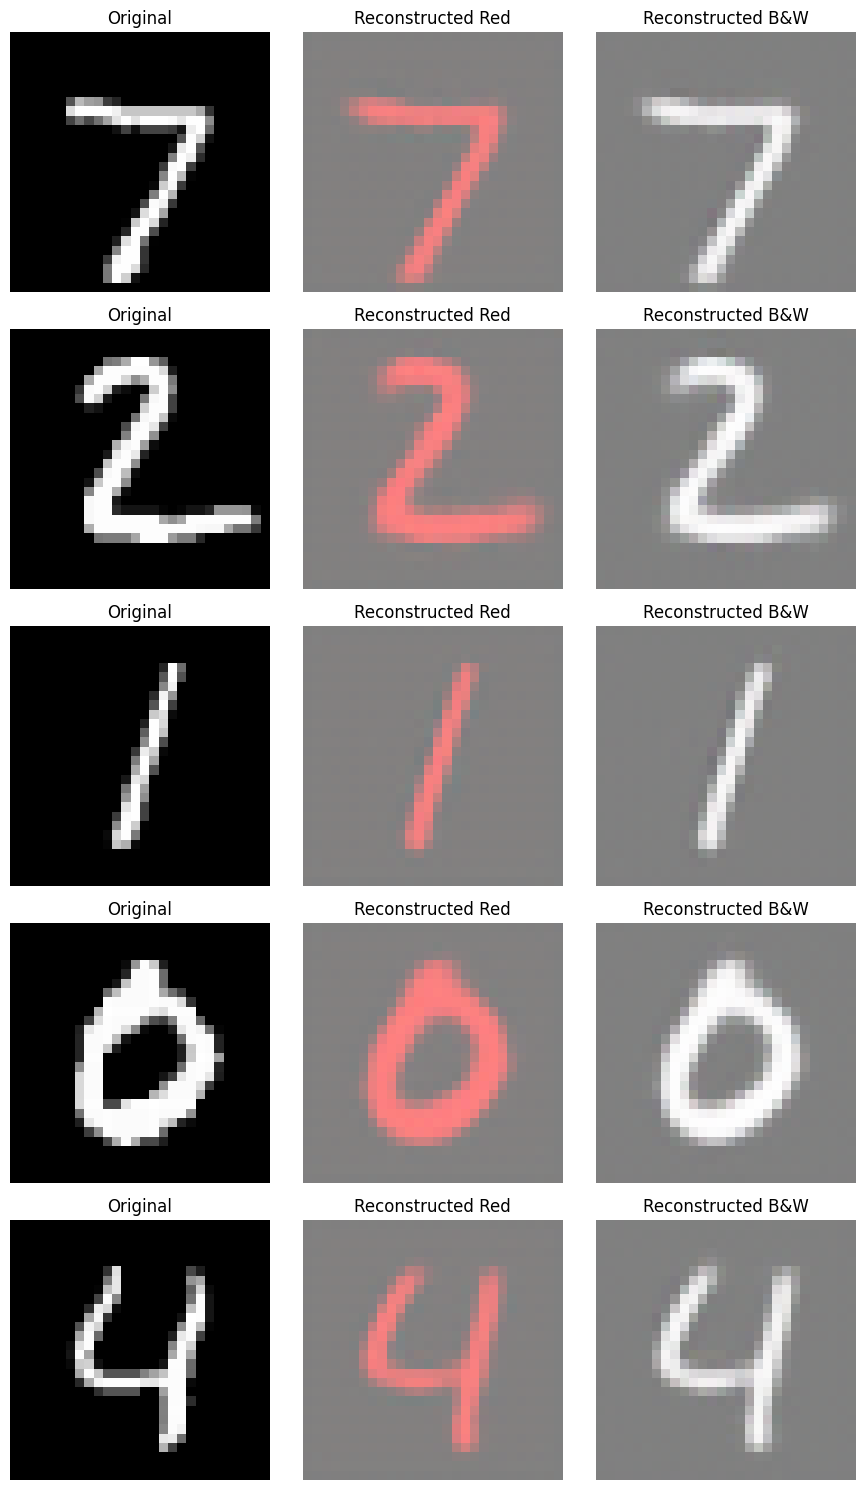

In [18]:
# call the visualization function for reconstructed images (both with color applied and b&w)
visualize_color_reconstructions(best_encoder, best_decoder)

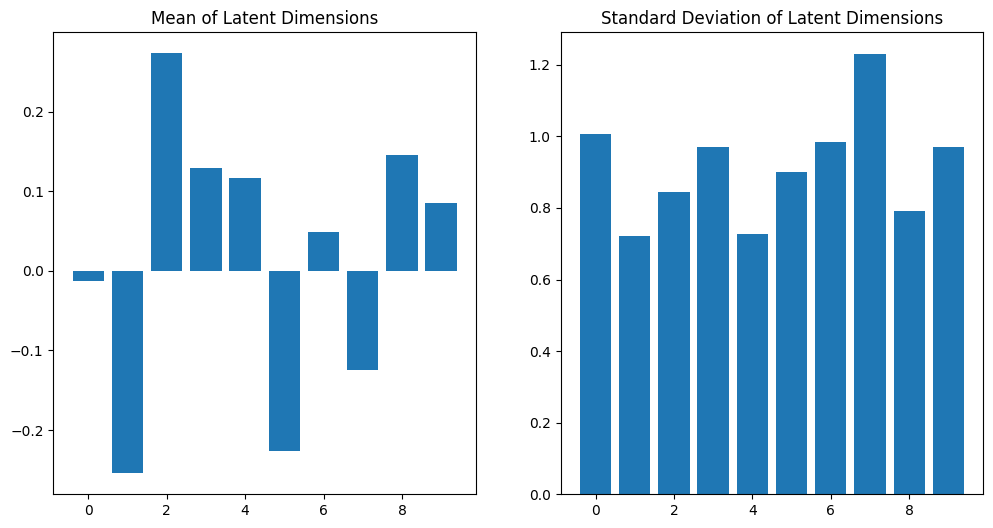

(array([-0.01233618, -0.25418818,  0.27322218,  0.12963876,  0.11617686,
        -0.22581547,  0.04844287, -0.12512222,  0.14517733,  0.0848039 ],
       dtype=float32),
 array([1.0051974 , 0.7208574 , 0.843972  , 0.9706417 , 0.7272302 ,
        0.8997077 , 0.9847703 , 1.2292222 , 0.79114765, 0.9701423 ],
       dtype=float32))

In [19]:
# extract latent_dim from the best_params dictionary
latent_dim = best_params['latent_dim']

# call the function to obtain mean and standard deviation of latent dimensions
encode_and_analyze_latent_space(encoder=best_encoder,
                                test_loader=test_loader,
                                device=device,
                                latent_dim=latent_dim)

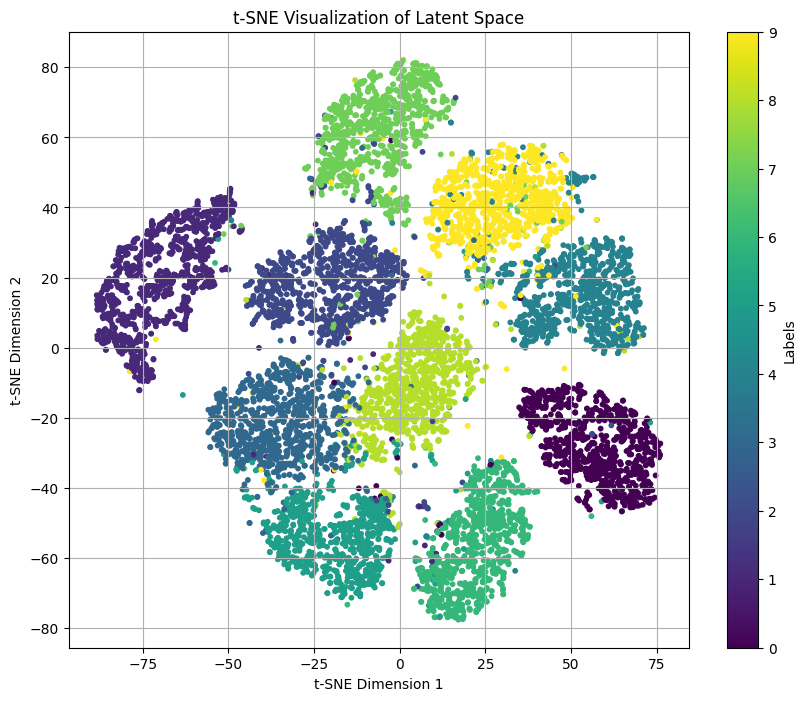

In [20]:
# call the latent space visualization function (t-sne)
visualize_latent_space(best_encoder, test_loader, covariate_dim)

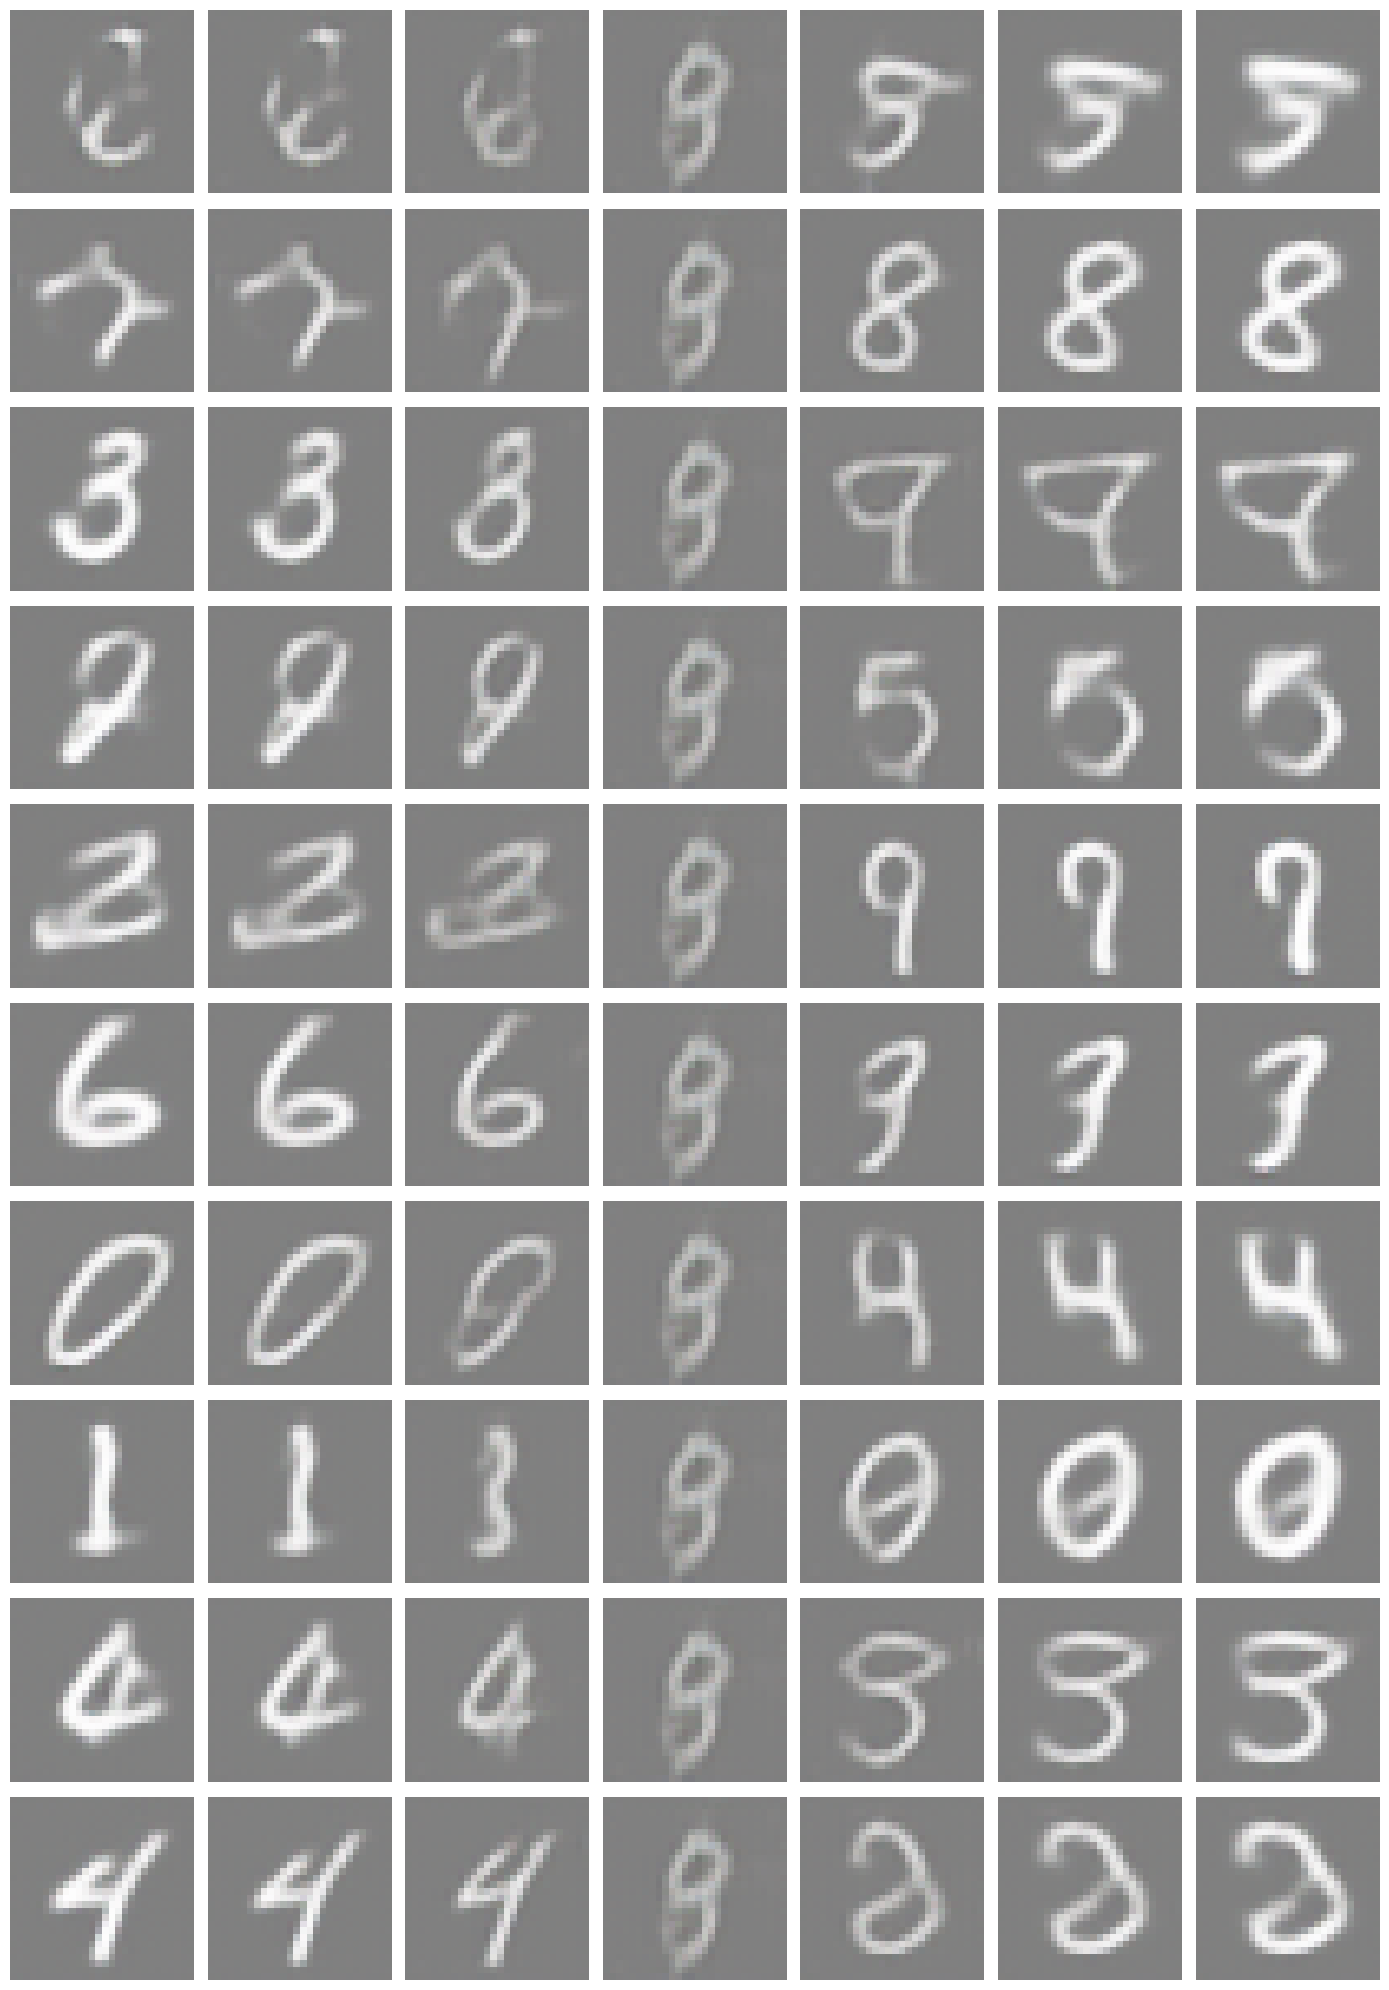

In [21]:
# call the latent dimensions visualization function
visualize_latent_dimensions(best_decoder, covariate_dim=covariate_dim)

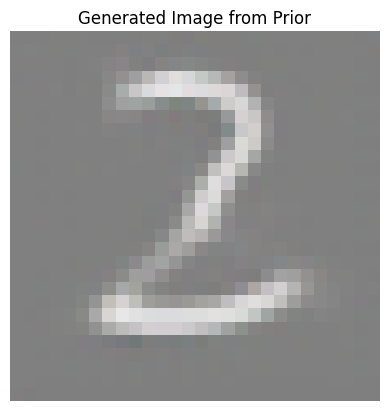

In [22]:
prior = IsotropicGaussianPrior(latent_dim=latent_dim, sigma_z=sigma_z, device=device)
generated_image = generate_image_from_prior(prior, best_decoder, latent_dim, device)